In [45]:
import random
import pandas as pd
import numpy as np
import igraph
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cross_validation import KFold
from sklearn.metrics import f1_score
from sklearn import preprocessing
from scipy.spatial.distance import cosine
import nltk
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn import decomposition
import sklearn.feature_extraction.text as text
import networkx as nx
from scipy.sparse.linalg import svds

In [48]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [35]:
pwd

u'/Users/vincent/OneDrive/axa/DS winter school/winter_school_DS_QH2017/prg'

In [28]:
#cd ~

In [29]:
nltk.download('punkt') # for tokenization
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/vincent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vincent/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [30]:
#cd /Users/vincent/OneDrive/axa/DS winter school/winter_school_DS_QH2017/prg

In [31]:
def preprocess_string(string):
    th_regexp = re.compile('[a-zA-Z\d]*-th')
    citation_regexp = re.compile('[a-zA-Z]+[\d]+')
    digit_regexp = re.compile('[\d]+')
    double_whitespace_regexp = re.compile('\s[\s]+')
    non_alphabet_regexp = re.compile('[\W]')
    one_letter_regexp = re.compile('\s[a-zA-Z]\s')
    two_letters_regexp = re.compile('\s[a-zA-Z][a-zA-Z]\s')   
    
    
    
    tagged_tokens = nltk.pos_tag(nltk.word_tokenize(string))
    
    verbs_tags_set = set(['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'])
    
    resulted_tokens = [token for (token, tag) in tagged_tokens if tag not in verbs_tags_set]
    
    for (token,tag) in tagged_tokens:
        if tag not in verbs_tags_set:
            resulted_tokens.append(token)
            
    result = " ".join(resulted_tokens)


    result = string
    result = th_regexp.sub('', result)
#     result = citation_regexp.sub('', result)
    result = digit_regexp.sub('', result)
    result = non_alphabet_regexp.sub(' ', result)
    result = one_letter_regexp.sub(' ', result)
    result = two_letters_regexp.sub(' ', result)
    result = double_whitespace_regexp.sub(' ', result)    
    
    return result

In [32]:
pwd


u'/Users/vincent/OneDrive/axa/DS winter school/winter_school_DS_QH2017/prg'

In [37]:
with open("../input/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info = list(reader)
# vectorizer = TfidfVectorizer(stop_words="english", max_df=0.75, ngram_range=(1,1))
# TFIDF_matrix = vectorizer.fit_transform(corpus)

# importance_vectorizer = TfidfVectorizer(stop_words="english", max_df=0.0001, ngram_range=(1,1))
# TFIDF_matrix_sparse = importance_vectorizer.fit_transform(corpus)
# num_topics = 20
# U, S, V = svds(TFIDF_matrix_sparse, k=num_topics)
# TOPIC_matrix = np.dot(TFIDF_matrix, V.transpose())

In [38]:
corpus = [preprocess_string(element[5]) for element in node_info]

In [39]:
vectorizer = TfidfVectorizer(stop_words="english", max_df=0.75, ngram_range=(1,1))
TFIDF_matrix = vectorizer.fit_transform(corpus)
num_topics = 100
_,_, V = svds(TFIDF_matrix, k=num_topics)
TOPIC_matrix = TFIDF_matrix.dot(V.transpose())
del V

In [40]:
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

# data loading and preprocessing 

# the columns of the data frame below are: 
# (1) paper unique ID (integer)
# (2) publication year (integer)
# (3) paper title (string)
# (4) authors (strings separated by ,)
# (5) name of journal (optional) (string)
# (6) abstract (string) - lowercased, free of punctuation except intra-word dashes


def get_features(data_fname, info_fname, portion, with_labels=True, node_info = None, tfidf_mat=None,
                 topic_mat=None, graph=None):
    with open(data_fname, "r") as f:
        reader = csv.reader(f)
        data_set = list(reader)

    data_set = [element[0].split(" ") for element in data_set]
    

#     with open(info_fname, "r") as f:
#         reader = csv.reader(f)
#         node_info  = list(reader)
        
        
    if portion == 1.0:
        print "one portion", portion
        to_keep = range(len(data_set))
    else:                       
        #to test code we select sample
        print "portion", portion
        random.seed(22)
        to_keep = random.sample(range(len(data_set)), k=int(round(len(data_set)*portion)))            
    
    data_set = [data_set[i] for i in to_keep]
    
    perm = [i for i in to_keep]
    
    
    valid_ids=set()
    for element in data_set:
        valid_ids.add(element[0])
        valid_ids.add(element[1])
        
    if node_info is None:
        tmp=[element for element in node_info if element[0] in valid_ids ]
        node_info=tmp
        del tmp



    IDs = []
    ID_pos={}
    for element in node_info:
        ID_pos[element[0]]=len(IDs)
        IDs.append(element[0])
        
    print "build graph"
    if graph is None:
        graph = nx.Graph()
        edges = []    
        nodes = set()
        all_edges = []
        for i in xrange(len(data_set)):
            source = data_set[i][0]
            target = data_set[i][1]
            nodes.add(source)
            nodes.add(target)
        
            if with_labels:
                if data_set[i][2] == "1":
                    edges.append((source, target))
            else:
                edges.append((source, target))
            all_edges.append((source, target))
        
        graph.add_nodes_from(nodes)
        graph.add_edges_from(edges)
    else:
        all_edges = []
        for i in xrange(len(data_set)):
            source = data_set[i][0]
            target = data_set[i][1]
            all_edges.append((source, target))
        
    
    clustering_coeff = nx.clustering(graph)
    pr = nx.pagerank(graph, alpha=0.9)
    jaccard_coeff = nx.jaccard_coefficient(graph, all_edges)
    adamic_index = nx.adamic_adar_index(graph, all_edges)
    pref_attach = nx.preferential_attachment(graph, all_edges)
    ress_alloc = nx.resource_allocation_index(graph, all_edges)
#     soundarajan = nx.cn_soundarajan_hopcroft(graph, all_edges)
#     community = nx.within_inter_cluster(graph, all_edges)
    hubs,auths=nx.hits(graph,max_iter=1000)

    # graph features
    neighbor_count_source = []
    neighbor_count_target = []
    neighbor_sim = []
    clustering_coeff_source = []
    clustering_coeff_target = []
    graph_jaccoby_authors = []
    graph_jaccard_coeff = []
    pr_coeff_source = []
    pr_coeff_target = []
    
    graph_ress_alloc = [p for u,v,p in ress_alloc]
#     graph_soundarajan = [p for u,v,p in soundarajan]
    
    graph_adamic_index = [p for u,v,p in adamic_index]
    graph_pref_attach = [p for u,v,p in pref_attach]
    hubs_feature_source = []
    hubs_feature_target = []
    auths_feature_source = []
    auths_feature_target = []
    
    graph_jaccard_coeff = [p for u,v,p in jaccard_coeff]
    
#     print np.size(graph_adamic_index)

    
    
#     graph_cosine_authors = []

    # we will use three basic features:

    # number of overlapping words in title
    overlap_title = []

    # temporal distance between the papers
    temp_diff = []

    # number of common authors
    comm_auth = []
    
    # tfidf similarities
    tfidf_cos = []
    
#     topic model
    topic_sim = []   
    
    # Important Topics
#     U, S, V = np.linalg.svd(tfidf_mat.toarray())
#     num_topics = 20
#     Imp_topics = np.dot(A,V[:k,:].transpose())
    
    # Jaccard index
    
    # Cosine similarity
    
    
    
    

#     if tfidf_mat == None or topic_mat == None:
#         corpus = [preprocess_string(element[5]) for element in node_info]
        
#         if tfidf_mat == None:
#             vectorizer = TfidfVectorizer(stop_words="english", max_df=0.75, ngram_range=(1,1))
#             TFIDF_matrix = vectorizer.fit_transform(corpus)
#         else:
#             TFIDF_matrix = tfidf_mat
        
#         if topic_mat == None:
#             tm_vectorizer = text.CountVectorizer(stop_words='english', min_df=20)
#             dtm = tm_vectorizer.fit_transform(corpus).toarray()
    
#             num_topics = 30
#             clf = decomposition.NMF(n_components=num_topics)
#             TOPIC_matrix = clf.fit_transform(dtm)
#             TOPIC_matrix = TOPIC_matrix / np.sum(TOPIC_matrix, axis=1, keepdims=True)
#         else:
#             TOPIC_matrix = topic_mat                                    
#     else:
#         TFIDF_matrix = tfidf_mat
#         TOPIC_matrix = topic_mat

    counter = 0
    for i in xrange(len(data_set)):
        source = data_set[i][0]
        target = data_set[i][1]
    
    
        source_info = node_info[ID_pos[source]]
        target_info = node_info[ID_pos[target]]
    
        # convert to lowercase and tokenize
        source_title = source_info[2].lower().split(" ")
        # remove stopwords
        source_title = [token for token in source_title if token not in stpwds]
        source_title = [stemmer.stem(token) for token in source_title]
    
        target_title = target_info[2].lower().split(" ")
        target_title = [token for token in target_title if token not in stpwds]
        target_title = [stemmer.stem(token) for token in target_title]
    
        source_auth = source_info[3].split(",")
        target_auth = target_info[3].split(",")
        
        
        v1 = tfidf_mat[ID_pos[source],:].toarray()[0]
        v2 = tfidf_mat[ID_pos[target],:].toarray()[0]        

#         v1 = Imp_topics[ID_pos[source],:].toarray()[0]
#         v2 = Imp_topics[ID_pos[target],:].toarray()[0]        

        
        temp_cosine = 0.0
        
        if np.linalg.norm(v1)!= 0 and np.linalg.norm(v2) != 0 :
            temp_cosine = cosine(v1, v2)
            
        tfidf_cos.append(temp_cosine)
        
        
        v1 = topic_mat[ID_pos[source],:]
        v2 = topic_mat[ID_pos[target],:]
        
        topic_cosine = 0.0
        if np.linalg.norm(v1)!= 0 and np.linalg.norm(v2) != 0 :
            topic_cosine = cosine(v1, v2)         
            
        topic_sim.append(topic_cosine)
            
            
        neighbors_source = len(list(graph.neighbors(source)))
        neighbors_target = len(list(graph.neighbors(target)))
        neighbor_count_source.append(neighbors_source)
        neighbor_count_target.append(neighbors_target)
        neighbors_source = set(list(graph.neighbors(source)))
        neighbors_target = set(list(graph.neighbors(target)))
        neighbor_sim.append(
            len(neighbors_source.intersection(neighbors_target)))
        clustering_coeff_source.append(clustering_coeff[source])
        clustering_coeff_target.append(clustering_coeff[target])
        authors_source = set(source_auth)
        authors_target = set(target_auth)
        graph_jaccoby_authors.append(float(len(authors_source.intersection(authors_target))) / float(len(authors_source.union(authors_target))))
        pr_coeff_source.append(pr[source])
        pr_coeff_target.append(pr[target])
                
        hubs_feature_source.append(hubs[source])
        hubs_feature_target.append(hubs[target])
        auths_feature_source.append(auths[source])
        auths_feature_target.append(auths[target])
        
        
        
    
        overlap_title.append(len(set(source_title).intersection(set(target_title))))
        temp_diff.append(int(source_info[1]) - int(target_info[1]))
        comm_auth.append(len(set(source_auth).intersection(set(target_auth))))
        
        
    
        if counter % 10000 == 0:
            print counter, "training examples processsed"
        counter += 1
        
#     tfidf_source = vectorizer.fit(source_abstracts)._tfidf.idf_
#     tfidf_target = vectorizer.fit(target_abstracts)._tfidf.idf_
    
		
    # convert list of lists into array
    # documents as rows, unique words as columns (i.e., example as rows, features as columns)
#     features = [overlap_title, temp_diff, comm_auth]
#     if tfidf_mat is not None:
#         features.append(tfidf_cos)
#     if topic_mat is not None:
#         features.append(topic_sim)
        
#     features = (np.array(features)).astype(float)
    features = (np.array([overlap_title, temp_diff,
                          comm_auth, tfidf_cos,
                          topic_sim,
                          neighbor_count_source,
                          neighbor_count_target,
                          neighbor_sim,
                          clustering_coeff_source,
                          clustering_coeff_target,
                          graph_jaccoby_authors,
                          pr_coeff_source,
                          pr_coeff_target,
                          graph_jaccard_coeff,
                          graph_adamic_index,
                          graph_pref_attach,
                          graph_ress_alloc,
                          hubs_feature_source,
                          hubs_feature_target,
                          auths_feature_source,
                          auths_feature_target
#                           graph_soundarajan
                         ]).T).astype(float)
    
    
#     print features

    # scale
    features = preprocessing.scale(features)    
    
    if with_labels:

        # convert labels into integers then into column array
        labels = [int(element[2]) for element in data_set]
        labels = list(labels)
        labels_array = np.array(labels)
        
        return perm, data_set, features, labels_array, graph
    else:
        labels_array = np.zeros(1)
        return perm, data_set, features, labels_array, graph

In [42]:
IDs, training_dataset, training_features, training_labels, graph = get_features("../input/training_set.txt",
                                                                    "node_information.csv",
                                                                    1.0,
                                                                    with_labels=True,
                                                                    node_info = node_info,
                                                                    tfidf_mat=TFIDF_matrix,
                                                                    topic_mat=TOPIC_matrix)
                                                                         #,topic_mat=TOPIC_matrix)

one portion 1.0
build graph
0 training examples processsed
10000 training examples processsed
20000 training examples processsed
30000 training examples processsed
40000 training examples processsed
50000 training examples processsed
60000 training examples processsed
70000 training examples processsed
80000 training examples processsed
90000 training examples processsed
100000 training examples processsed
110000 training examples processsed
120000 training examples processsed
130000 training examples processsed
140000 training examples processsed
150000 training examples processsed
160000 training examples processsed
170000 training examples processsed
180000 training examples processsed
190000 training examples processsed
200000 training examples processsed
210000 training examples processsed
220000 training examples processsed
230000 training examples processsed
240000 training examples processsed
250000 training examples processsed
260000 training examples processsed
270000 trainin

In [43]:
type(training_features)

numpy.ndarray

In [46]:
pd_tf = pd.DataFrame(training_features)

In [49]:

sns.set(style="white")

# Compute the correlation matrix
corr_training_features = pd_tf.corr()



In [55]:
corr_training_features

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.079281,0.133143,-0.457673,-0.452204,0.050396,0.028234,0.261447,0.052283,-0.019270,...,0.040206,0.029164,0.406052,0.268435,0.025744,0.271548,0.035506,0.014047,0.035506,0.014047
1,0.079281,1.000000,0.007704,-0.115546,-0.154287,0.048388,0.109655,0.079764,0.084261,-0.228606,...,0.021183,0.123229,0.083171,0.084254,0.059600,0.095207,0.066083,0.082107,0.066083,0.082107
2,0.133143,0.007704,1.000000,-0.242068,-0.187777,0.003557,-0.022009,0.090475,0.018753,0.022534,...,0.006639,-0.021780,0.246701,0.103146,-0.003734,0.138354,-0.000072,-0.017661,-0.000072,-0.017661
3,-0.457673,-0.115546,-0.242068,1.000000,0.820837,-0.068157,-0.050779,-0.342215,-0.041077,0.049767,...,-0.050944,-0.046655,-0.559050,-0.355364,-0.048515,-0.374230,-0.066237,-0.049163,-0.066237,-0.049163
4,-0.452204,-0.154287,-0.187777,0.820837,1.000000,-0.086328,-0.069973,-0.378876,-0.025152,0.087545,...,-0.069291,-0.067453,-0.553052,-0.388051,-0.059684,-0.391868,-0.076635,-0.060039,-0.076635,-0.060039
5,0.050396,0.048388,0.003557,-0.068157,-0.086328,1.000000,0.082565,0.401773,-0.221971,-0.066994,...,0.970730,0.068612,0.082151,0.380527,0.441495,0.292207,0.901346,0.096296,0.901346,0.096296
6,0.028234,0.109655,-0.022009,-0.050779,-0.069973,0.082565,1.000000,0.334856,-0.012857,-0.302175,...,0.048097,0.993667,-0.048428,0.317785,0.562982,0.250733,0.159519,0.960460,0.159519,0.960460
7,0.261447,0.079764,0.090475,-0.342215,-0.378876,0.401773,0.334856,1.000000,-0.038646,-0.146875,...,0.339386,0.313383,0.569894,0.991610,0.571797,0.872551,0.388101,0.319114,0.388101,0.319114
8,0.052283,0.084261,0.018753,-0.041077,-0.025152,-0.221971,-0.012857,-0.038646,1.000000,0.081121,...,-0.247545,-0.010589,0.150112,-0.030442,-0.100872,-0.007883,-0.195839,-0.018863,-0.195839,-0.018863
9,-0.019270,-0.228606,0.022534,0.049767,0.087545,-0.066994,-0.302175,-0.146875,0.081121,1.000000,...,-0.047717,-0.306877,0.112183,-0.136531,-0.183243,-0.104195,-0.100167,-0.276638,-0.100167,-0.276638


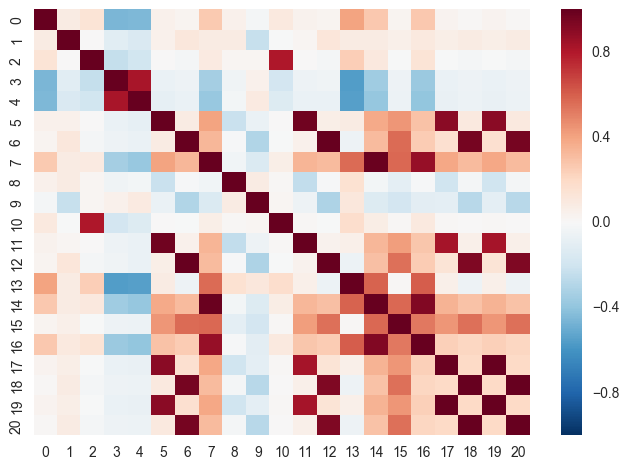

In [54]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_training_features, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_training_features)

In [56]:
IDs, test_dataset, test_features, _, _= get_features("../input/testing_set.txt", "node_information.csv", 1.0,
                                                  with_labels=False,
                                                  node_info = node_info,
                                                  tfidf_mat=TFIDF_matrix,
                                                  topic_mat=TOPIC_matrix,
                                                  graph = graph)
#                                                   topic_mat=TOPIC_matrix)

one portion 1.0
build graph
0 training examples processsed
10000 training examples processsed
20000 training examples processsed
30000 training examples processsed


In [57]:
classifier = RandomForestClassifier(n_estimators=300)
classifier.fit(training_features, training_labels)
pred=classifier.predict(test_features)
results = np.concatenate((np.reshape(IDs,(np.size(pred), 1)), np.reshape(pred, (np.size(pred),1))), axis=1)
with open("new_submission.txt", "w") as f:
    writer = csv.writer(f, )
    writer.writerow(['id','prediction'])
    writer.writerows(results)

In [ ]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)